In [2]:
import os
import zipfile

zip_path = "classification_dataset.zip"

extract_dir = "classification_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("✅ Extraction complete!")

✅ Extraction complete!


In [3]:
#📌 Project Workflow
#1. Understand the Dataset
#● Inspect dataset folder structure

import os
print(os.listdir("classification_dataset"))

['test', 'train', 'valid']


In [4]:
base_dir = "classification_dataset"

train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "valid")
test_dir  = os.path.join(base_dir, "test")

In [5]:
for folder in [train_dir, valid_dir, test_dir]:
    print(f"{folder} ->", os.listdir(folder))

classification_dataset\train -> ['bird', 'drone']
classification_dataset\valid -> ['bird', 'drone']
classification_dataset\test -> ['bird', 'drone']


In [6]:
#● Check number of images per class

for split in ["train", "valid", "test"]:
    path = os.path.join(base_dir, split)
    print(f"\n📁 {split} contains:")
    for cls in os.listdir(path):
        cls_path = os.path.join(path, cls)
        if os.path.isdir(cls_path):
            count = len(os.listdir(cls_path))
            print(f"  ├── {cls}: {count} images")


📁 train contains:
  ├── bird: 1414 images
  ├── drone: 1248 images

📁 valid contains:
  ├── bird: 217 images
  ├── drone: 225 images

📁 test contains:
  ├── bird: 121 images
  ├── drone: 94 images


In [7]:
#● Identify class imbalance

import pandas as pd

splits = ["train", "valid", "test"]
data_summary = []

for split in splits:
    split_path = os.path.join(base_dir, split)
    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        if os.path.isdir(cls_path):
            count = len(os.listdir(cls_path))
            data_summary.append([split, cls, count])

df = pd.DataFrame(data_summary, columns=["Split", "Class", "Image_Count"])
df

,Split,Class,Image_Count
0,train,bird,1414
1,train,drone,1248
2,valid,bird,217
3,valid,drone,225
4,test,bird,121
5,test,drone,94


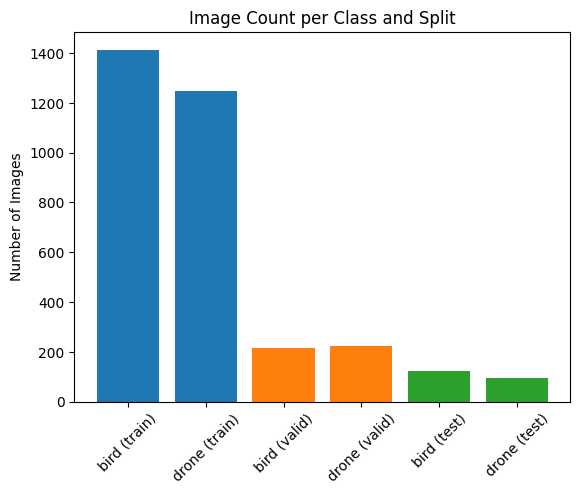

In [8]:
import matplotlib.pyplot as plt

for split in splits:
    subset = df[df["Split"] == split]
    plt.bar(subset["Class"] + " (" + split + ")", subset["Image_Count"])
plt.title("Image Count per Class and Split")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

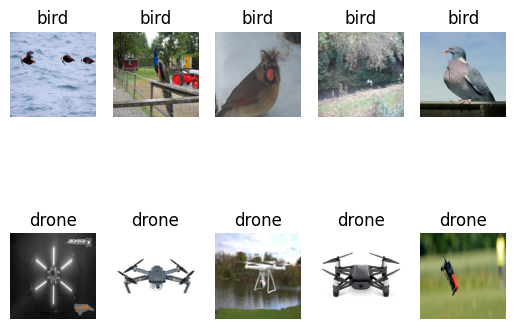

In [9]:
#● Visualize sample images

import random
from PIL import Image

def show_samples(dataset_dir, n=5):
    classes = os.listdir(dataset_dir)
    
    for i, cls in enumerate(classes):
        cls_path = os.path.join(dataset_dir, cls)
        sample_imgs = random.sample(os.listdir(cls_path), n)
        
        for j, img_name in enumerate(sample_imgs):
            img_path = os.path.join(cls_path, img_name)
            img = Image.open(img_path)
            
            plt.subplot(len(classes), n, i*n + j + 1)
            plt.imshow(img)
            plt.axis("off")
            plt.title(cls)
    plt.show()

show_samples(train_dir)

In [10]:
#2. Data Preprocessing
#● Normalize pixel values to [0, 1]
#● Resize images to a fixed size (224×224 for classification)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height = 224
img_width = 224
batch_size = 8

In [11]:
#3. Data Augmentation
#● Apply transformations: rotation, flipping, zoom, brightness, cropping

train_datagen = ImageDataGenerator(
    rescale=1./255,           
    rotation_range=30,         
    width_shift_range=0.1,    
    height_shift_range=0.1,   
    shear_range=0.1,          
    zoom_range=0.2,            
    horizontal_flip=True,      
    brightness_range=[0.8,1.2],
    fill_mode='nearest'        
)

valid_test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary' 
)

valid_data = valid_test_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_data = valid_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 2662 images belonging to 2 classes.
Found 442 images belonging to 2 classes.
Found 215 images belonging to 2 classes.


In [13]:
images, labels = next(train_data)
print("Image batch shape:", images.shape)
print("Label batch shape:", labels.shape)

Image batch shape: (8, 224, 224, 3)
Label batch shape: (8,)


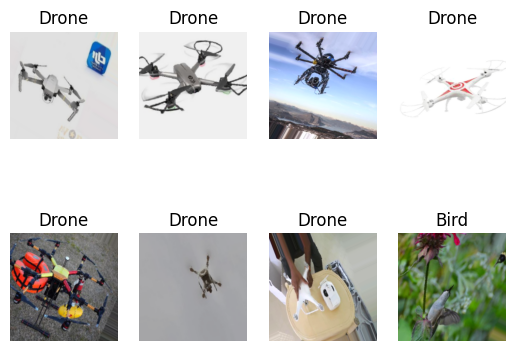

In [16]:
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(images[i])
    plt.title("Bird" if labels[i]==0 else "Drone")
    plt.axis('off')
plt.show()

In [17]:
#4. Model Building (Classification)
#● Custom CNN: Conv layers, pooling, dropout, batch normalization, dense output layer

from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

input_shape = (224, 224, 3)

custom_cnn = models.Sequential([
    layers.Conv2D(
        filters=16,                
        kernel_size=(3, 3),
        activation='relu',
        input_shape=input_shape
    ),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(32, (3, 3), activation='relu'), 
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dropout(0.3),            
    layers.Dense(64, activation='relu'),  
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid') 
])

custom_cnn.compile(optimizer=Adam(learning_rate=1e-4),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

custom_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 32)      128       
 chNormalization)                                                
                                                        

In [18]:
#● Transfer Learning: Load models like ResNet50, MobileNet, EfficientNetB0 and fine-tune

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
resnet_base.trainable = False

x = resnet_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)

resnet_model = Model(inputs=resnet_base.input, outputs=predictions)

resnet_model.compile(optimizer=Adam(learning_rate=1e-4),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [19]:
from tensorflow.keras.applications import MobileNetV2

mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
mobilenet_base.trainable = False

x = mobilenet_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)

mobilenet_model = Model(inputs=mobilenet_base.input, outputs=predictions)

mobilenet_model.compile(optimizer=Adam(learning_rate=1e-4),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

mobilenet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [20]:
from tensorflow.keras.applications import EfficientNetB0

efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
efficientnet_base.trainable = False

x = efficientnet_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)

efficientnet_model = Model(inputs=efficientnet_base.input, outputs=predictions)

efficientnet_model.compile(optimizer=Adam(learning_rate=1e-4),
                           loss='binary_crossentropy',
                           metrics=['accuracy'])

efficientnet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_3[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]'] 

In [22]:
#5. Model Training
#● Train both models
#● Use EarlyStopping & ModelCheckpoint
#● Track metrics: Accuracy, Precision, Recall, F1-score

import numpy as np
import time
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, accuracy_score

start_time = time.time()

early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
checkpoint = ModelCheckpoint('custom_cnn_best.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

history = custom_cnn.fit(
    train_data, 
    validation_data=valid_data, 
    epochs=12, 
    callbacks=[early_stop, checkpoint, reduce_lr], 
    workers=1, 
    use_multiprocessing=False
)

train_time = time.time() - start_time
print(f"\nTraining time: {train_time:.2f} seconds")

test_data.reset()
y_pred_prob = custom_cnn.predict(test_data, batch_size=16, verbose=1)
y_pred = np.where(y_pred_prob>0.5,1,0)
y_true = test_data.classes

accuracy = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy: {accuracy:.4f}")

report = classification_report(y_true, y_pred, target_names=['Bird','Drone'], output_dict=True)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Bird','Drone']))

custom_cnn_metrics = {
    'accuracy': accuracy,
    'precision': report['weighted avg']['precision'],
    'recall': report['weighted avg']['recall'],
    'f1_score': report['weighted avg']['f1-score'],
    'train_time': train_time
}

print("\nModel Metrics:", custom_cnn_metrics)

Epoch 1/12
333/333 [==============================] - ETA: 0s - loss: 0.4288 - accuracy: 0.8122
Epoch 1: val_loss improved from inf to 0.40147, saving model to custom_cnn_best.h5
333/333 [==============================] - 201s 603ms/step - loss: 0.4288 - accuracy: 0.8122 - val_loss: 0.4015 - val_accuracy: 0.8348 - lr: 2.5000e-05
Epoch 2/12
333/333 [==============================] - ETA: 0s - loss: 0.4162 - accuracy: 0.8095
Epoch 2: val_loss improved from 0.40147 to 0.38181, saving model to custom_cnn_best.h5
333/333 [==============================] - 200s 600ms/step - loss: 0.4162 - accuracy: 0.8095 - val_loss: 0.3818 - val_accuracy: 0.8439 - lr: 2.5000e-05
Epoch 3/12
333/333 [==============================] - ETA: 0s - loss: 0.3985 - accuracy: 0.8159
Epoch 3: val_loss improved from 0.38181 to 0.37273, saving model to custom_cnn_best.h5
333/333 [==============================] - 200s 601ms/step - loss: 0.3985 - accuracy: 0.8159 - val_loss: 0.3727 - val_accuracy: 0.8507 - lr: 2.5000e-05

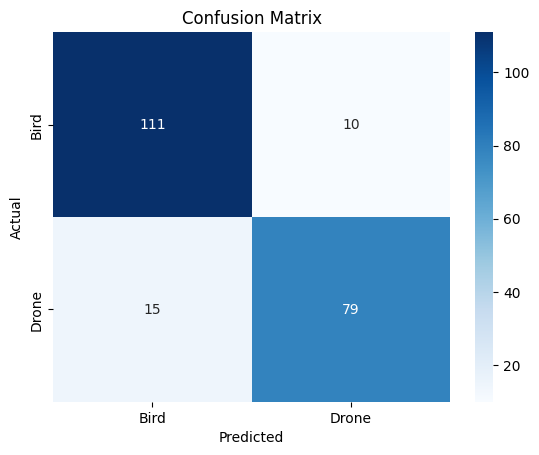

In [23]:
#6. Model Evaluation
#● Evaluate test results with confusion matrix & classification report

import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Bird','Drone'], yticklabels=['Bird','Drone'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

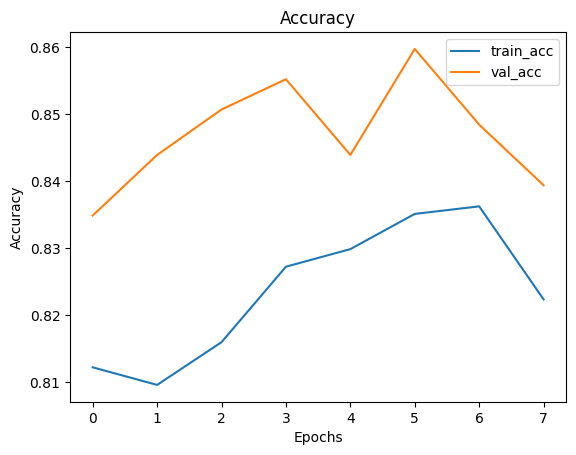

In [24]:
#● Plot accuracy/loss graphs

plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

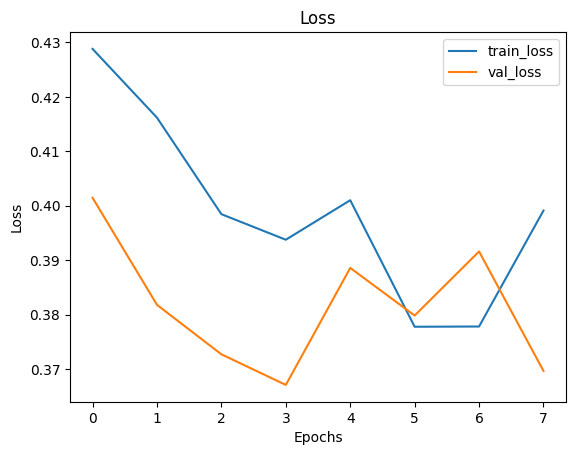

In [25]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
start_time = time.time()

early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
checkpoint = ModelCheckpoint('resnet_best.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

history = resnet_model.fit(
    train_data, 
    validation_data=valid_data, 
    epochs=12, 
    callbacks=[early_stop, checkpoint, reduce_lr], 
    workers=1, 
    use_multiprocessing=False
)

train_time = time.time() - start_time
print(f"\nTraining time: {train_time:.2f} seconds")

test_data.reset()
y_pred_prob = resnet_model.predict(test_data, batch_size=16, verbose=1)
y_pred = np.where(y_pred_prob>0.5,1,0)
y_true = test_data.classes

accuracy = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy: {accuracy:.4f}")

report = classification_report(y_true, y_pred, target_names=['Bird','Drone'], output_dict=True)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Bird','Drone']))

resnet_metrics = {
    'accuracy': accuracy,
    'precision': report['weighted avg']['precision'],
    'recall': report['weighted avg']['recall'],
    'f1_score': report['weighted avg']['f1-score'],
    'train_time': train_time
}

print("\nModel Metrics:", resnet_metrics)

Epoch 1/12
333/333 [==============================] - ETA: 0s - loss: 0.6906 - accuracy: 0.5635
Epoch 1: val_loss improved from inf to 0.63668, saving model to resnet_best.h5


C:\Users\vidya\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


333/333 [==============================] - 524s 2s/step - loss: 0.6906 - accuracy: 0.5635 - val_loss: 0.6367 - val_accuracy: 0.6154 - lr: 1.0000e-04
Epoch 2/12
333/333 [==============================] - ETA: 0s - loss: 0.6461 - accuracy: 0.6202
Epoch 2: val_loss improved from 0.63668 to 0.63013, saving model to resnet_best.h5
333/333 [==============================] - 490s 1s/step - loss: 0.6461 - accuracy: 0.6202 - val_loss: 0.6301 - val_accuracy: 0.6154 - lr: 1.0000e-04
Epoch 3/12
333/333 [==============================] - ETA: 0s - loss: 0.6357 - accuracy: 0.6409
Epoch 3: val_loss improved from 0.63013 to 0.61051, saving model to resnet_best.h5
333/333 [==============================] - 490s 1s/step - loss: 0.6357 - accuracy: 0.6409 - val_loss: 0.6105 - val_accuracy: 0.6674 - lr: 1.0000e-04
Epoch 4/12
333/333 [==============================] - ETA: 0s - loss: 0.6242 - accuracy: 0.6533
Epoch 4: val_loss improved from 0.61051 to 0.60373, saving model to resnet_best.h5
333/333 [=======

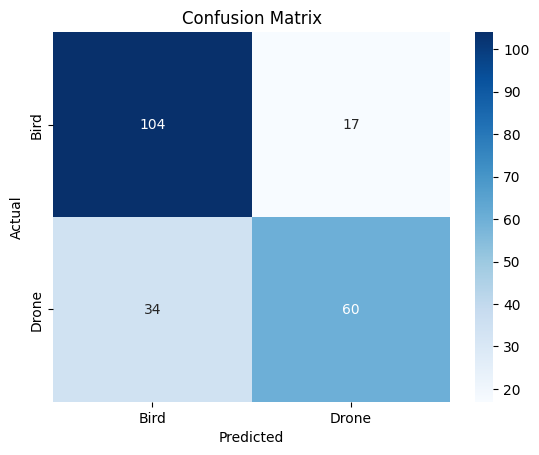

In [27]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Bird','Drone'], yticklabels=['Bird','Drone'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

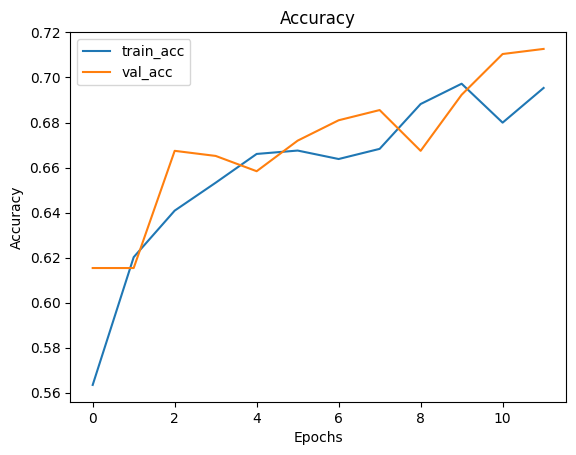

In [28]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

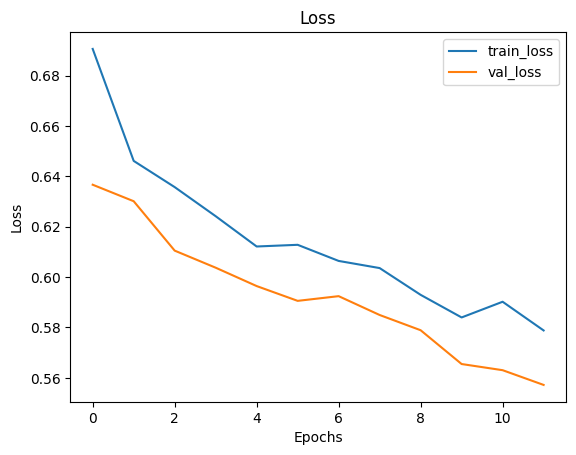

In [29]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
start_time = time.time()

early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
checkpoint = ModelCheckpoint('mobilenet_best.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

history = mobilenet_model.fit(
    train_data, 
    validation_data=valid_data, 
    epochs=12, 
    callbacks=[early_stop, checkpoint, reduce_lr], 
    workers=1, 
    use_multiprocessing=False
)

train_time = time.time() - start_time
print(f"\nTraining time: {train_time:.2f} seconds")

test_data.reset()
y_pred_prob = mobilenet_model.predict(test_data, batch_size=16, verbose=1)
y_pred = np.where(y_pred_prob>0.5,1,0)
y_true = test_data.classes

accuracy = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy: {accuracy:.4f}")

report = classification_report(y_true, y_pred, target_names=['Bird','Drone'], output_dict=True)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Bird','Drone']))

mobilenet_metrics = {
    'accuracy': accuracy,
    'precision': report['weighted avg']['precision'],
    'recall': report['weighted avg']['recall'],
    'f1_score': report['weighted avg']['f1-score'],
    'train_time': train_time
}

print("\nModel Metrics:", mobilenet_metrics)

Epoch 1/12
333/333 [==============================] - ETA: 0s - loss: 0.3104 - accuracy: 0.8689
Epoch 1: val_loss improved from inf to 0.15239, saving model to mobilenet_best.h5


C:\Users\vidya\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


333/333 [==============================] - 194s 530ms/step - loss: 0.3104 - accuracy: 0.8689 - val_loss: 0.1524 - val_accuracy: 0.9434 - lr: 1.0000e-04
Epoch 2/12
333/333 [==============================] - ETA: 0s - loss: 0.1503 - accuracy: 0.9463
Epoch 2: val_loss improved from 0.15239 to 0.11428, saving model to mobilenet_best.h5
333/333 [==============================] - 170s 511ms/step - loss: 0.1503 - accuracy: 0.9463 - val_loss: 0.1143 - val_accuracy: 0.9593 - lr: 1.0000e-04
Epoch 3/12
333/333 [==============================] - ETA: 0s - loss: 0.1104 - accuracy: 0.9591
Epoch 3: val_loss improved from 0.11428 to 0.10168, saving model to mobilenet_best.h5
333/333 [==============================] - 171s 512ms/step - loss: 0.1104 - accuracy: 0.9591 - val_loss: 0.1017 - val_accuracy: 0.9615 - lr: 1.0000e-04
Epoch 4/12
333/333 [==============================] - ETA: 0s - loss: 0.0935 - accuracy: 0.9669
Epoch 4: val_loss improved from 0.10168 to 0.08967, saving model to mobilenet_best.h

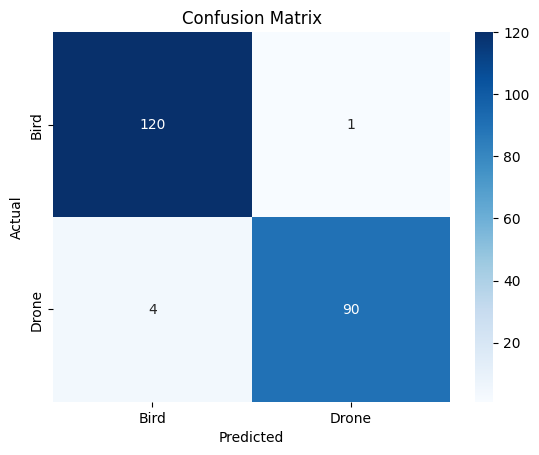

In [31]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Bird','Drone'], yticklabels=['Bird','Drone'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

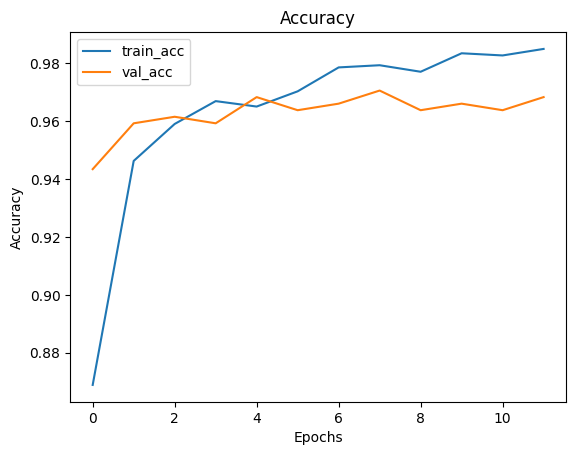

In [32]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

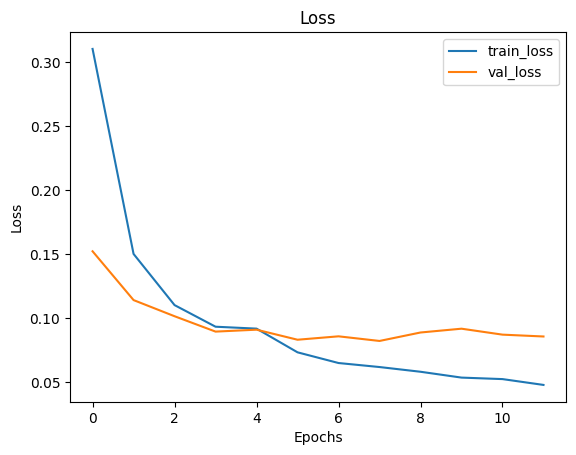

In [33]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [34]:
from sklearn.utils import class_weight

start_time = time.time()

early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
checkpoint = ModelCheckpoint('efficientnet_best.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

classes = np.unique(train_data.classes)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_data.classes
)
class_weights = dict(enumerate(class_weights))

history = efficientnet_model.fit(
    train_data, 
    validation_data=valid_data, 
    epochs=12, 
    callbacks=[early_stop, checkpoint, reduce_lr], 
    class_weight=class_weights,
    workers=1, 
    use_multiprocessing=False
)

train_time = time.time() - start_time
print(f"\nTraining time: {train_time:.2f} seconds")

test_data.reset()
y_pred_prob = efficientnet_model.predict(test_data, batch_size=16, verbose=1)
y_pred = np.where(y_pred_prob>0.5,1,0)
y_true = test_data.classes

accuracy = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy: {accuracy:.4f}")

report = classification_report(y_true, y_pred, target_names=['Bird','Drone'], output_dict=True, zero_division=0)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Bird','Drone'], zero_division=0))

efficientnet_metrics = {
    'accuracy': accuracy,
    'precision': report['weighted avg']['precision'],
    'recall': report['weighted avg']['recall'],
    'f1_score': report['weighted avg']['f1-score'],
    'train_time': train_time
}

print("\nModel Metrics:", efficientnet_metrics)

Epoch 1/12
333/333 [==============================] - ETA: 0s - loss: 0.6952 - accuracy: 0.4989
Epoch 1: val_loss improved from inf to 0.69601, saving model to efficientnet_best.h5


C:\Users\vidya\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


333/333 [==============================] - 367s 990ms/step - loss: 0.6952 - accuracy: 0.4989 - val_loss: 0.6960 - val_accuracy: 0.4910 - lr: 1.0000e-04
Epoch 2/12
333/333 [==============================] - ETA: 0s - loss: 0.6960 - accuracy: 0.5120
Epoch 2: val_loss improved from 0.69601 to 0.69325, saving model to efficientnet_best.h5
333/333 [==============================] - 342s 1s/step - loss: 0.6960 - accuracy: 0.5120 - val_loss: 0.6932 - val_accuracy: 0.5090 - lr: 1.0000e-04
Epoch 3/12
333/333 [==============================] - ETA: 0s - loss: 0.6954 - accuracy: 0.4771
Epoch 3: val_loss did not improve from 0.69325
333/333 [==============================] - 326s 979ms/step - loss: 0.6954 - accuracy: 0.4771 - val_loss: 0.6962 - val_accuracy: 0.4910 - lr: 1.0000e-04
Epoch 4/12
333/333 [==============================] - ETA: 0s - loss: 0.6953 - accuracy: 0.5079
Epoch 4: val_loss improved from 0.69325 to 0.69316, saving model to efficientnet_best.h5

Epoch 4: ReduceLROnPlateau reduci

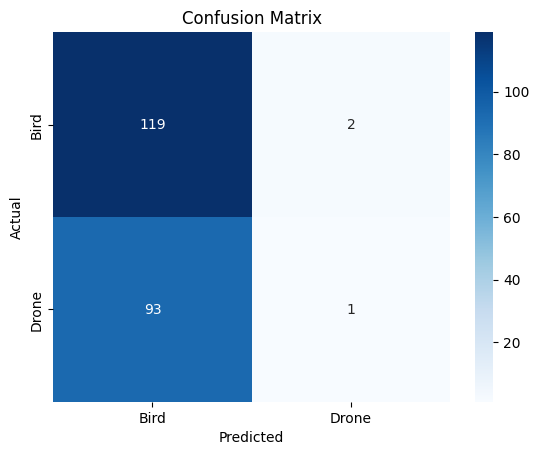

In [35]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Bird','Drone'], yticklabels=['Bird','Drone'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

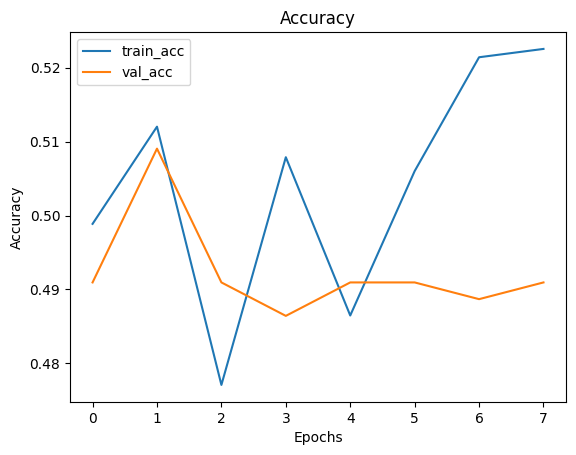

In [36]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

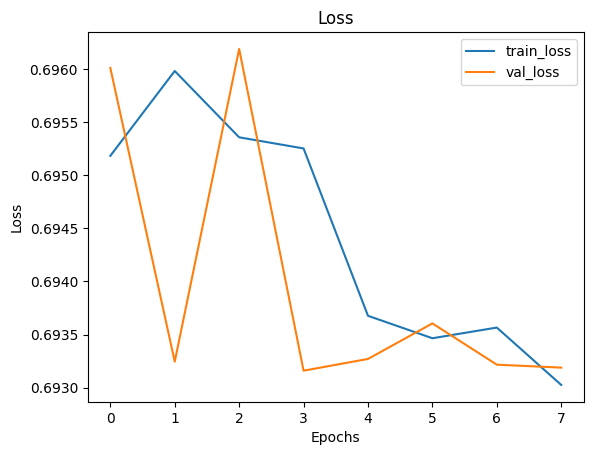

In [37]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [38]:
#7. Model Comparison
#● Compare accuracy, training time, and generalization performance

all_models_metrics = {
    'Custom_CNN': custom_cnn_metrics,
    'ResNet50': resnet_metrics,
    'MobileNetV2': mobilenet_metrics,
    'EfficientNetB0': efficientnet_metrics
}

df = pd.DataFrame(all_models_metrics).T
df

,accuracy,precision,recall,f1_score,train_time
Custom_CNN,0.883721,0.883876,0.883721,0.883309,1607.274363
ResNet50,0.762791,0.764815,0.762791,0.758784,5942.879297
MobileNetV2,0.976744,0.977041,0.976744,0.976698,2255.838999
EfficientNetB0,0.558140,0.461643,0.558140,0.411249,2794.355734


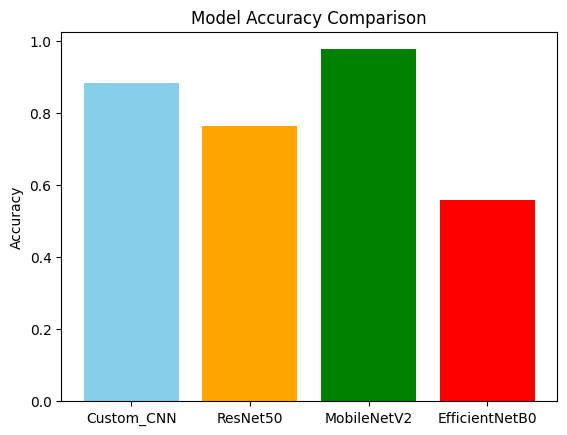

In [39]:
plt.bar(df.index, df['accuracy'], color=['skyblue','orange','green','red'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.show()

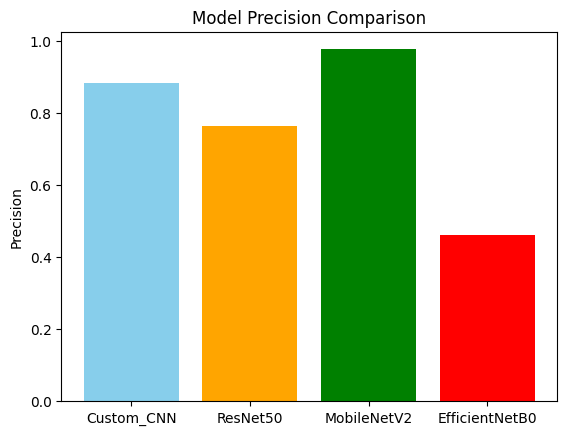

In [40]:
plt.bar(df.index, df['precision'], color=['skyblue','orange','green','red'])
plt.ylabel('Precision')
plt.title('Model Precision Comparison')
plt.show()

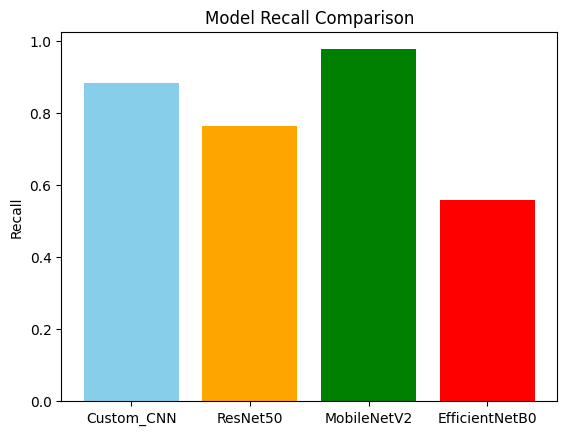

In [41]:
plt.bar(df.index, df['recall'], color=['skyblue','orange','green','red'])
plt.ylabel('Recall')
plt.title('Model Recall Comparison')
plt.show()

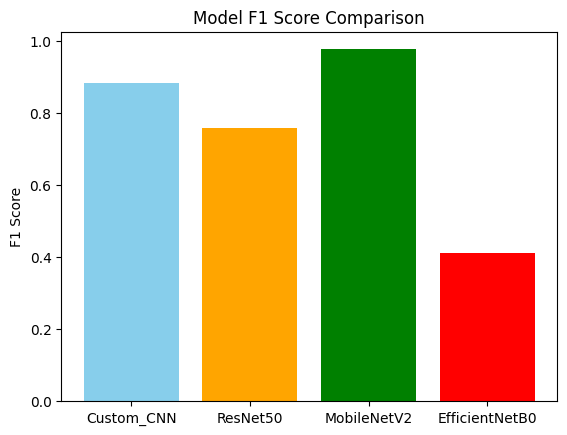

In [42]:
plt.bar(df.index, df['f1_score'], color=['skyblue','orange','green','red'])
plt.ylabel('F1 Score')
plt.title('Model F1 Score Comparison')
plt.show()

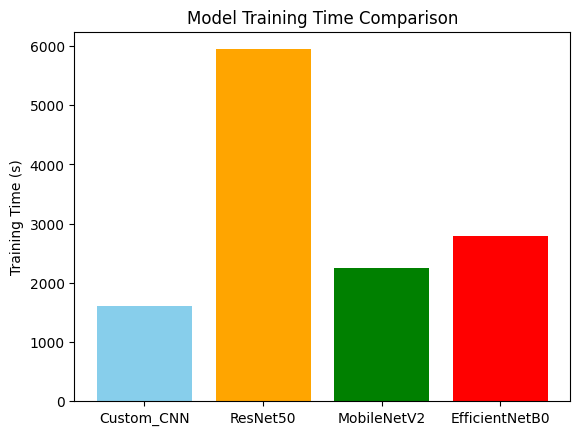

In [43]:
plt.bar(df.index, df['train_time'], color=['skyblue','orange','green','red'])
plt.ylabel('Training Time (s)')
plt.title('Model Training Time Comparison')
plt.show()

In [44]:
#● Save the best performing model for Streamlit deployment

best_model_name = df['accuracy'].idxmax()
print("Best Model:", best_model_name)

model_file_map = {
    'Custom_CNN': 'custom_cnn_best.h5',
    'ResNet50': 'resnet_best.h5',
    'MobileNetV2': 'mobilenet_best.h5',
    'EfficientNetB0': 'efficientnet_best.h5'
}

best_model_file = model_file_map[best_model_name]

from tensorflow.keras.models import load_model
best_model = load_model(best_model_file)
best_model.save('best_model_for_streamlit.h5')
print("Saved best model for Streamlit deployment:", best_model_file)

Best Model: MobileNetV2


C:\Users\vidya\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved best model for Streamlit deployment: mobilenet_best.h5


In [45]:
for layer in mobilenet_base.layers[:-50]:
    layer.trainable = False
for layer in mobilenet_base.layers[-50:]:
    layer.trainable = True

mobilenet_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('mobilenet_finetuned_best.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

start_time = time.time()

history = mobilenet_model.fit(
    train_data,
    validation_data=valid_data,
    epochs=8,  
    callbacks=[early_stop, checkpoint, reduce_lr],
    workers=1,
    use_multiprocessing=False
)

train_time = time.time() - start_time
print(f"\nFine-tuning training time: {train_time:.2f} seconds")

test_data.reset()
y_pred_prob = mobilenet_model.predict(test_data, batch_size=8, verbose=1)
y_pred = np.where(y_pred_prob > 0.5, 1, 0)
y_true = test_data.classes

accuracy = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy after fine-tuning: {accuracy:.4f}")

report = classification_report(y_true, y_pred, target_names=['Bird','Drone'], output_dict=True)
print("\nClassification Report after fine-tuning:")
print(classification_report(y_true, y_pred, target_names=['Bird','Drone']))

mobilenet_metrics = {
    'accuracy': accuracy,
    'precision': report['weighted avg']['precision'],
    'recall': report['weighted avg']['recall'],
    'f1_score': report['weighted avg']['f1-score'],
    'train_time': train_time
}

print("\nFine-tuned Model Metrics:", mobilenet_metrics)

Epoch 1/8
333/333 [==============================] - ETA: 0s - loss: 0.2020 - accuracy: 0.9237
Epoch 1: val_loss improved from inf to 0.07124, saving model to mobilenet_finetuned_best.h5
333/333 [==============================] - 622s 2s/step - loss: 0.2020 - accuracy: 0.9237 - val_loss: 0.0712 - val_accuracy: 0.9729 - lr: 1.0000e-05
Epoch 2/8
333/333 [==============================] - ETA: 0s - loss: 0.1712 - accuracy: 0.9328
Epoch 2: val_loss did not improve from 0.07124
333/333 [==============================] - 243s 727ms/step - loss: 0.1712 - accuracy: 0.9328 - val_loss: 0.0819 - val_accuracy: 0.9729 - lr: 1.0000e-05
Epoch 3/8
333/333 [==============================] - ETA: 0s - loss: 0.1498 - accuracy: 0.9365
Epoch 3: val_loss did not improve from 0.07124

Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
333/333 [==============================] - 279s 836ms/step - loss: 0.1498 - accuracy: 0.9365 - val_loss: 0.0719 - val_accuracy: 0.9796 - lr: 1.0000e-05